In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date
import marine as mhw

In [3]:
def read_sst_ncfiles(years, file_pattern, lat_min, lat_max, lon_min, lon_max):
    """
    指定した year リスト (例: range(1983,2013) や [2011]) と
    file_pattern.format(year) に従い、
    指定した lat/lon 範囲で SST を空間平均（単純平均）して
    (t_ordinal, sst_mean) を返す。
    """
    t_list = []
    sst_list = []

    for yr in years:
        fname = file_pattern.format(yr)
        print("[INFO] Reading:", fname)
        ds_nc = netCDF4.Dataset(fname, "r")

        time_var = ds_nc.variables["time"][:]  # shape=(T,)
        time_units = ds_nc.variables["time"].units
        cftime_objs = netCDF4.num2date(time_var, time_units)
        t_ordinal = np.array([
            datetime.datetime(d.year, d.month, d.day).toordinal()
            for d in cftime_objs
        ])

        lat_1d = ds_nc.variables["lat"][:]
        lon_1d = ds_nc.variables["lon"][:]

        # SST (time, lat, lon)
        sst_3d = ds_nc.variables["sst"][:]
        ds_nc.close()

        # lat_min..max, lon_min..max の範囲を指定
        lat_inds = np.where((lat_1d >= lat_min) & (lat_1d <= lat_max))[0]
        lon_inds = np.where((lon_1d >= lon_min) & (lon_1d <= lon_max))[0]

        # スライスして空間平均
        sst_subset = sst_3d[:, lat_inds[:, np.newaxis], lon_inds]
        sst_mean_1d = np.nanmean(sst_subset, axis=(1,2))

        t_list.append(t_ordinal)
        sst_list.append(sst_mean_1d)

    t_all   = np.concatenate(t_list)
    sst_all = np.concatenate(sst_list)

    return t_all, sst_all


[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1983.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1984.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1985.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1986.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1987.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1988.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1989.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1990.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1991.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1992.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1993.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1994.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1995.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1996.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1997.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1998.nc
[INFO] R

C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


[INFO] # of MHW events (2011) = 5
[INFO] 2011 anomaly max = 4.352 on 2003-06-14

=== Category Days & Fractions (2011) ===
  Total days : 365 days
  Moderate  : 90 days  -> 24.66%
  Strong    : 22 days  -> 6.03%
  Severe    : 0 days  -> 0.00%
  Extreme   : 0 days  -> 0.00%

[INFO] MHW events in 2011 (clim=1983-2012):
  Event #1: start=2003-01-01, end=2003-01-06, peak=2003-01-02, duration=6 days
    Event #1 total days: 6 
      Moderate : 6 -> 100.00%
      Strong   : 0 -> 0.00%
      Severe   : 0 -> 0.00%
      Extreme  : 0 -> 0.00%
  Event #2: start=2003-06-01, end=2003-07-01, peak=2003-06-14, duration=31 days
    Event #2 total days: 31 
      Moderate : 19 -> 61.29%
      Strong   : 12 -> 38.71%
      Severe   : 0 -> 0.00%
      Extreme  : 0 -> 0.00%
  Event #3: start=2003-07-12, end=2003-07-22, peak=2003-07-14, duration=11 days
    Event #3 total days: 11 
      Moderate : 11 -> 100.00%
      Strong   : 0 -> 0.00%
      Severe   : 0 -> 0.00%
      Extreme  : 0 -> 0.00%
  Event #4: 

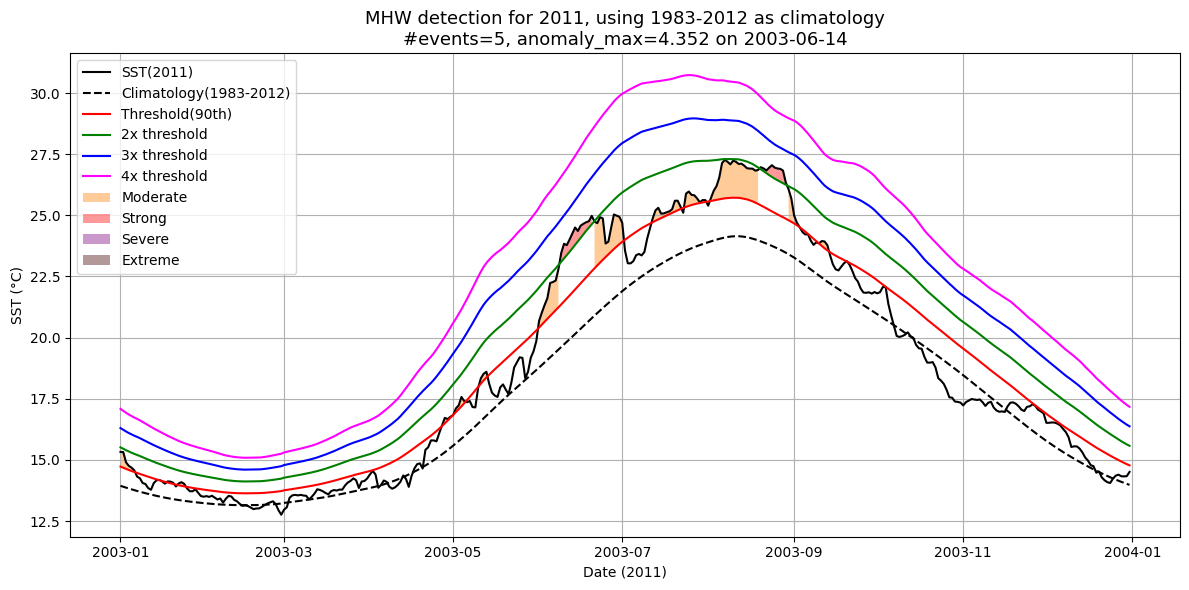

In [4]:
def main():
    """
    要望:
     - 全体の Moderate/Strong/Severe/Extreme 日数・割合
     - 各イベントごとに Moderate/Strong/Severe/Extreme の日数・割合

    コードの流れ:
      1) 気候期間(1983～2012)の SST 取得
      2) 2011年の SST 取得
      3) mhw.detect で MHW イベント検出
      4) カテゴリ分割し、全体の割合を表示
      5) イベントごとに (start～end) の区間で各カテゴリ日数・割合を出力
    """

    # ======= パラメータ設定 =======
    lat_min, lat_max = 41, 44
    lon_min, lon_max = 7, 10
    file_pattern = r"C:/Users/81909/MHW1/DATA/sst.day.mean.{}.nc"

    # (A) 1983～2012 => 気候期間
    years_clim = range(1983, 2013)
    t_clim, sst_clim = read_sst_ncfiles(
        years_clim,
        file_pattern,
        lat_min, lat_max,
        lon_min, lon_max
    )
    print("[INFO] 1983-2012 shape =", t_clim.shape, sst_clim.shape)

    # (B) 2011年 => 検出対象
    years_target = [2003]
    t_2003, sst_2003 = read_sst_ncfiles(
        years_target,
        file_pattern,
        lat_min, lat_max,
        lon_min, lon_max
    )
    print("[INFO] 2011 shape =", t_2003.shape, sst_2003.shape)

    # (C) MHW detect
    mhw_res, clim_res = mhw.detect(
        t_2003,
        sst_2003,
        climatologyPeriod=[1983,2012],
        pctile=90,
        windowHalfWidth=5,
        smoothPercentile=True,
        smoothPercentileWidth=31,
        minDuration=5,
        joinAcrossGaps=False,
        maxGap=2,
        maxPadLength=False,
        coldSpells=False,
        alternateClimatology=[t_clim, sst_clim],
        Ly=False
    )
    print("[INFO] # of MHW events (2011) =", mhw_res["n_events"])

    # (D) 2011年の可視化用
    day1_2011 = date(2003,1,1).toordinal()
    dayend_2011 = date(2003,12,31).toordinal()
    idx_2011 = (t_2003 >= day1_2011) & (t_2003 <= dayend_2011)

    sst_2011_sub    = sst_2003[idx_2011]
    seas_2011_sub   = clim_res["seas"][idx_2011]
    thresh_2011_sub = clim_res["thresh"][idx_2011]
    dates_2011 = [date.fromordinal(int(x)) for x in t_2003[idx_2011]]

    # 2x,3x,4x
    delta_2011 = thresh_2011_sub - seas_2011_sub
    thresh2x_2011_sub = seas_2011_sub + 2*delta_2011
    thresh3x_2011_sub = seas_2011_sub + 3*delta_2011
    thresh4x_2011_sub = seas_2011_sub + 4*delta_2011

    # cat_value = sst - seas
    cat_value = sst_2011_sub - seas_2011_sub
    val_max = np.nanmax(cat_value)
    idx_max = np.nanargmax(cat_value)
    max_date = dates_2011[idx_max]
    print(f"[INFO] 2011 anomaly max = {val_max:.3f} on {max_date}")

    # カテゴリ分割
    cat_mod = np.where((cat_value >= delta_2011)     & (cat_value < 2*delta_2011), cat_value, np.nan)
    cat_str = np.where((cat_value >= 2*delta_2011)   & (cat_value < 3*delta_2011), cat_value, np.nan)
    cat_sev = np.where((cat_value >= 3*delta_2011)   & (cat_value < 4*delta_2011), cat_value, np.nan)
    cat_ext = np.where( cat_value >= 4*delta_2011, cat_value, np.nan)

    # 全日数
    total_days = len(sst_2011_sub)

    # 各カテゴリの日数
    mod_days = np.sum(~np.isnan(cat_mod))
    str_days = np.sum(~np.isnan(cat_str))
    sev_days = np.sum(~np.isnan(cat_sev))
    ext_days = np.sum(~np.isnan(cat_ext))

    # ===== 全体結果 =====
    print("\n=== Category Days & Fractions (2011) ===")
    print(f"  Total days : {total_days} days")
    print(f"  Moderate  : {mod_days} days  -> {100.0*mod_days/total_days:.2f}%")
    print(f"  Strong    : {str_days} days  -> {100.0*str_days/total_days:.2f}%")
    print(f"  Severe    : {sev_days} days  -> {100.0*sev_days/total_days:.2f}%")
    print(f"  Extreme   : {ext_days} days  -> {100.0*ext_days/total_days:.2f}%")

    # ===== グラフ描画 =====
    sst_2011_ma      = np.ma.masked_invalid(sst_2011_sub)
    seas_2011_ma     = np.ma.masked_invalid(seas_2011_sub)
    thresh_2011_ma   = np.ma.masked_invalid(thresh_2011_sub)
    thresh2x_2011_ma = np.ma.masked_invalid(thresh2x_2011_sub)
    thresh3x_2011_ma = np.ma.masked_invalid(thresh3x_2011_sub)
    thresh4x_2011_ma = np.ma.masked_invalid(thresh4x_2011_sub)

    cat_mod_ma = np.ma.masked_invalid(cat_mod)
    cat_str_ma = np.ma.masked_invalid(cat_str)
    cat_sev_ma = np.ma.masked_invalid(cat_sev)
    cat_ext_ma = np.ma.masked_invalid(cat_ext)

    fig, ax = plt.subplots(figsize=(12,6))

    ax.plot(dates_2011, sst_2011_ma,      color='black', linestyle='-',  label="SST(2011)")
    ax.plot(dates_2011, seas_2011_ma,     color='black', linestyle='--', label="Climatology(1983-2012)")
    ax.plot(dates_2011, thresh_2011_ma,   color='red',   linestyle='-',  label="Threshold(90th)")
    ax.plot(dates_2011, thresh2x_2011_ma, color='green', linestyle='-',  label="2x threshold")
    ax.plot(dates_2011, thresh3x_2011_ma, color='blue',  linestyle='-',  label="3x threshold")
    ax.plot(dates_2011, thresh4x_2011_ma, color='magenta', linestyle='-', label="4x threshold")

    # 塗りつぶし
    ax.fill_between(
        dates_2011,
        seas_2011_sub + delta_2011,
        seas_2011_sub + cat_mod_ma,
        where=~np.isnan(cat_mod_ma),
        facecolor=(1.0,0.6,0.2), alpha=0.5, label="Moderate"
    )
    ax.fill_between(
        dates_2011,
        seas_2011_sub + 2*delta_2011,
        seas_2011_sub + cat_str_ma,
        where=~np.isnan(cat_str_ma),
        facecolor=(1.0,0.2,0.2), alpha=0.5, label="Strong"
    )
    ax.fill_between(
        dates_2011,
        seas_2011_sub + 3*delta_2011,
        seas_2011_sub + cat_sev_ma,
        where=~np.isnan(cat_sev_ma),
        facecolor=(0.6,0.2,0.6), alpha=0.5, label="Severe"
    )
    ax.fill_between(
        dates_2011,
        seas_2011_sub + 4*delta_2011,
        seas_2011_sub + cat_ext_ma,
        where=~np.isnan(cat_ext_ma),
        facecolor=(0.4,0.2,0.2), alpha=0.5, label="Extreme"
    )

    ax.set_title(
        f"MHW detection for 2011, using 1983-2012 as climatology\n"
        f"#events={mhw_res['n_events']}, anomaly_max={val_max:.3f} on {max_date}",
        fontsize=13
    )
    ax.set_xlabel("Date (2011)")
    ax.set_ylabel("SST (°C)")
    ax.grid(True)

    # ===== イベントごとのカテゴリ日数/割合 =====
    print("\n[INFO] MHW events in 2011 (clim=1983-2012):")

    # 全期間のインデックス
    idx_full_year = np.where(idx_2011)[0]  # これで "t_2011" → "2011年" のインデックスがわかる

    dates_2011_array = np.array([d.toordinal() for d in dates_2011])
    if mhw_res["n_events"] > 0:
        for i in range(mhw_res["n_events"]):
            start_day = mhw_res["date_start"][i]
            end_day   = mhw_res["date_end"][i]

            # イベント開始/終了を ordinal へ
            start_ord = start_day.toordinal()
            end_ord   = end_day.toordinal()

            # イベント区間に対応する "idx_full_year" のうち
            # 日付が start_ord～end_ord のインデックスを抽出
            event_idx = np.where((dates_2011_array >= start_ord) & (dates_2011_array <= end_ord))[0]

            event_len = len(event_idx)  # イベント日数(=durationでもある)

            # そのイベント区間の cat_mod, cat_str, cat_sev, cat_ext が何日ずつあるか
            ev_cat_mod = cat_mod[event_idx]
            ev_cat_str = cat_str[event_idx]
            ev_cat_sev = cat_sev[event_idx]
            ev_cat_ext = cat_ext[event_idx]

            mod_ev_days = np.sum(~np.isnan(ev_cat_mod))
            str_ev_days = np.sum(~np.isnan(ev_cat_str))
            sev_ev_days = np.sum(~np.isnan(ev_cat_sev))
            ext_ev_days = np.sum(~np.isnan(ev_cat_ext))

            print(f"  Event #{i+1}: "
                  f"start={start_day}, end={end_day}, peak={mhw_res['date_peak'][i]}, "
                  f"duration={mhw_res['duration'][i]} days")

            print(f"    Event #{i+1} total days: {event_len} ")
            if event_len > 0:
                # 割合を計算
                print(f"      Moderate : {mod_ev_days} -> {100.0*mod_ev_days/event_len:.2f}%")
                print(f"      Strong   : {str_ev_days} -> {100.0*str_ev_days/event_len:.2f}%")
                print(f"      Severe   : {sev_ev_days} -> {100.0*sev_ev_days/event_len:.2f}%")
                print(f"      Extreme  : {ext_ev_days} -> {100.0*ext_ev_days/event_len:.2f}%")
            else:
                print("      (No days in this event?)")

    # 凡例
    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), loc="upper left")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()